In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import acquire
import prepare
import evaluate
from scipy import stats
import itertools

# PROJECT OVERVIEW

The goal of this project is to create a predictive model that can predict the tax assessed values of single family properties based on the features of the home. The model is trained on data from zillow found on kaggle and looks specifically at transactions for the year 2017.

## Project Description

Zillow attempted with varying degrees of success to predict housing values based of off several data points. We will use a smaller subset of that data to train and test our models and eventually present the best performing model.

## Goals

1. Find the drivers of property value. 
2. Make a model that performs better than baseline. 
3. Refine or create a better model. 
4. Give recommendations for new data to create better models.

***

## Aquiring Data


Data is store in codeups SQL database and a SQL query is run to pull the data. This is done using the acquire.py module. acquire.get_zillow_data() houses the SQL query and returns a pandas dataframe. This is then prepped by prepare.py to be used in the exploration and modeling.

prepare.prep_zillow() calls acquire.get_zillow_data() and returns a more usable dataframe.

***

## Preparing Data

The data actually gets cleaned and aquired in one function call above. Some things to note about the preparation:
1. Nulls are removed because they are less than 1% of the data.
2. 'yearbuilt' is converted to age during 2017
3. 'fips' which is converted to a categorical dummy variable:
ie. 1 or 0 if it is part of a particular county
4. This is also stored in .csv file for later use.

In [2]:
df = prepare.prep_zillow()
df.info()

Prepped csv exist, pulling data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52319 non-null  float64
 1   bathroomcnt                   52319 non-null  float64
 2   calculatedfinishedsquarefeet  52319 non-null  float64
 3   taxvaluedollarcnt             52319 non-null  float64
 4   age                           52319 non-null  float64
 5   fips_la_county                52319 non-null  int64  
 6   fips_orange_county            52319 non-null  int64  
 7   fips_ventura_county           52319 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 3.2 MB


### Split the data

Data is split into train, validate, and test sets to prevent overfitting and to allow for data to be used to evaluate the model.


In [3]:
# split the data set into train, validate, and test
# here we use 'taxvaluedollarcnt' as the y value, and
# choose not to stratify the data set because it is not categorical
train, validate, test = prepare.split_data(df, 
    'taxvaluedollarcnt', stratify=False)

### Removing Outliers

This is down seperately to allow more control over the data. The function prepare.remove_outliers() removes outliers based on a given z-score. I chose 4 becuase it maintains a lot of data and does not fully remove Ventura County from the data set.

In [4]:
# lets remove the outliers from the train, validate and test df
# outliers are removed to make the data more normal and easier to work with
# extreme values are removed but this constitutes a small amount of data.
train = prepare.remove_outliers(train, 4)
validate = prepare.remove_outliers(validate, 4)
test = prepare.remove_outliers(test, 4)

***

## Exploratory Data Analysis
Here I will look at the data and see if there are any interesting trends. Do some Hypothesis testing, statistical tests, and visualizations.

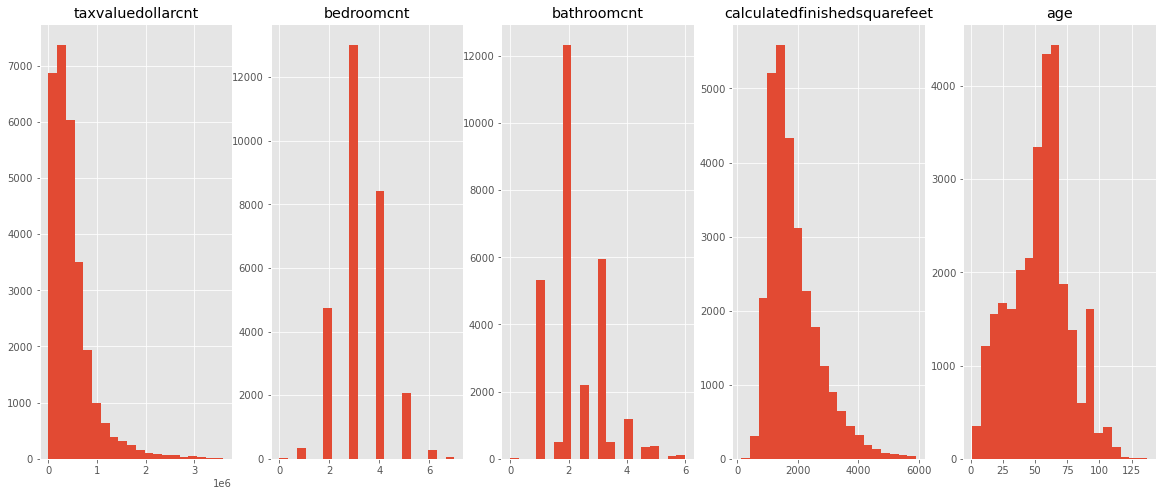

In [5]:
# a quick overview of the data after outliers are removed
evaluate.histograms_of_data(train)

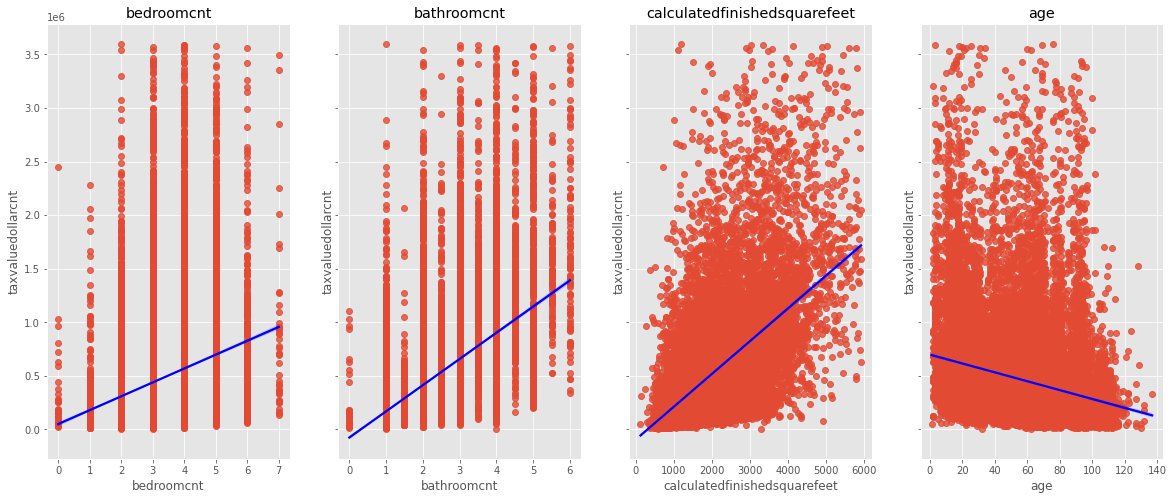

In [6]:
# Here I can look at the correlation between the features and the target
evaluate.graph_variables_vs_target(train)

### Question 1:
    
    Is there a correlation between calculated square feet and the value of the property?



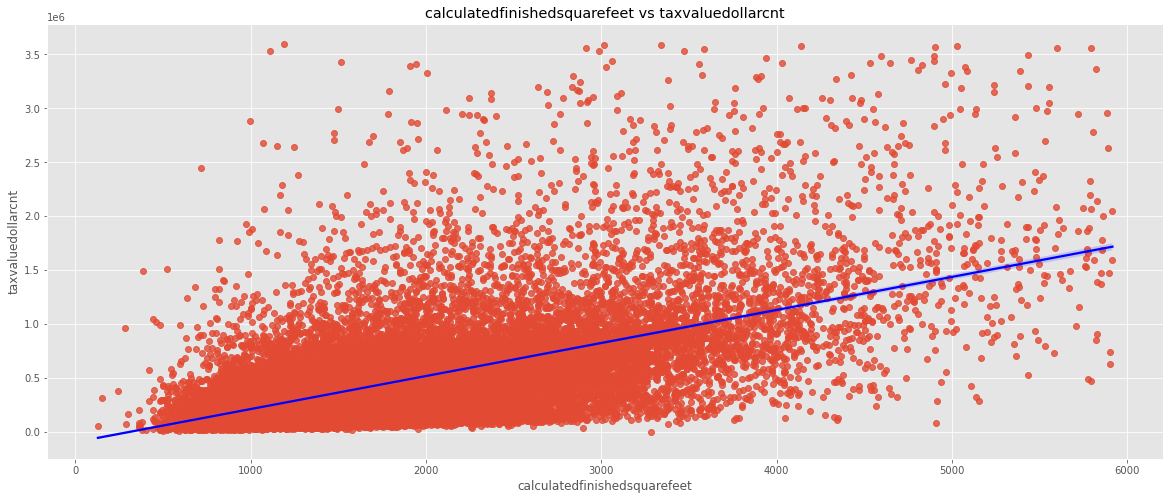

In [7]:
# pull a scatterplot to see
evaluate.q1_graph(train)

    Lets test this hypothesis

$H_0$ : There is no linear relationship between square feet and the value of the property.
 
$H_A$ : There is a linear relationship between square feet and the value of the property.

In [8]:
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
corr, p = stats.pearsonr(train['calculatedfinishedsquarefeet'], train['taxvaluedollarcnt'])
corr, p
# P-value is less than 0.05, so we reject null hypothesis

(0.5828920833091596, 0.0)

    Reject the null hypothesis and conclude that there is a linear relationship between square feet and the value of the property.

~~$H_0$ : There is no linear relationship between square feet and the value of the property.~~
 
$H_A$ : There is a linear relationship between square feet and the value of the property.

    Sqft affects the value of the property

## Question 2:
    
    Is there a correlation between bathrooms and the value of the property?



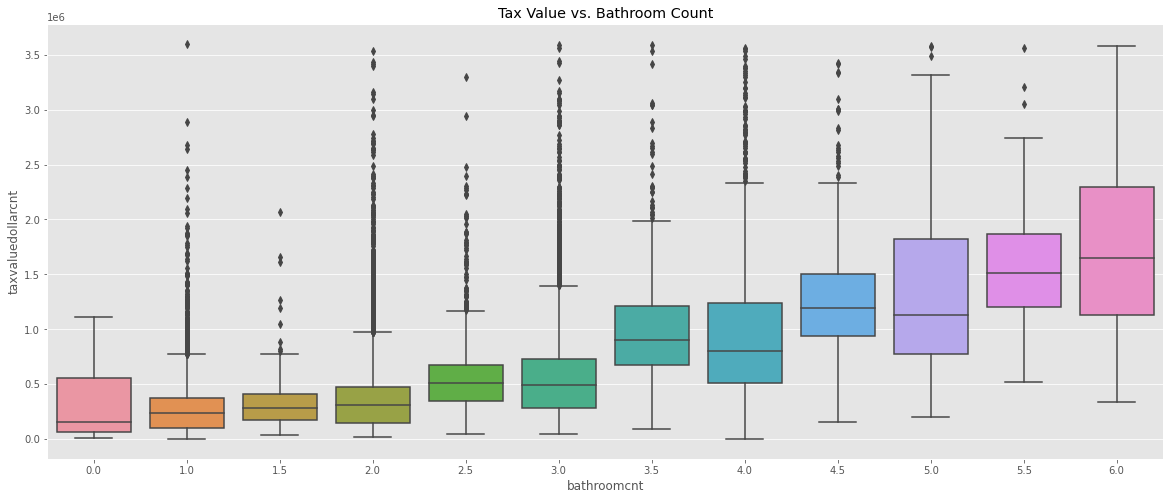

In [9]:
#pull a boxplot to see
evaluate.q2_graph(train)

    Lets test this hypothesis

$H_0$ : There is no linear relationship between bathroom count and the value of the property.
 
$H_A$ : There is a linear relationship between bathroom count and the value of the property.

In [10]:
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
corr, p = stats.pearsonr(train['bathroomcnt'], train['taxvaluedollarcnt'])
corr, p
# P-value is less than 0.05, so we reject null hypothesis

(0.5091860450543995, 0.0)

    Lets test this hypothesis

~~$H_0$ : There is no linear relationship between bathroom count and the value of the property.~~
 
$H_A$ : There is a linear relationship between bathroom count and the value of the property.

    Number of bathrooms affects the value of the property

## Question 3:

    Is there a correlation between the number of bedrooms and the value of the property?

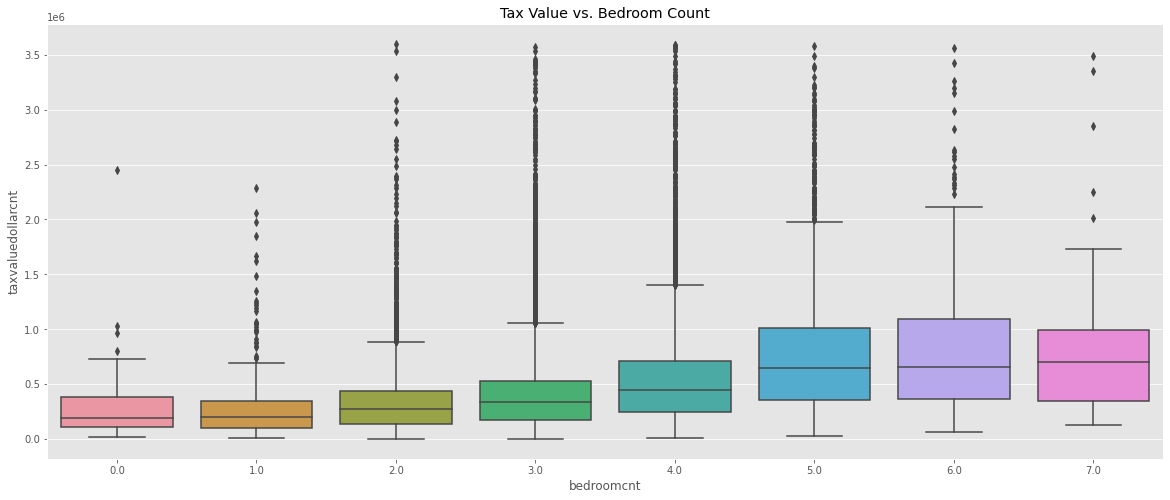

In [11]:
# pull a boxplot to see
evaluate.q3_graph(train)


    Bedroom count also affects the value of the property

## Question 4:

    Is there a correlation between the buildings age and the value of the property?

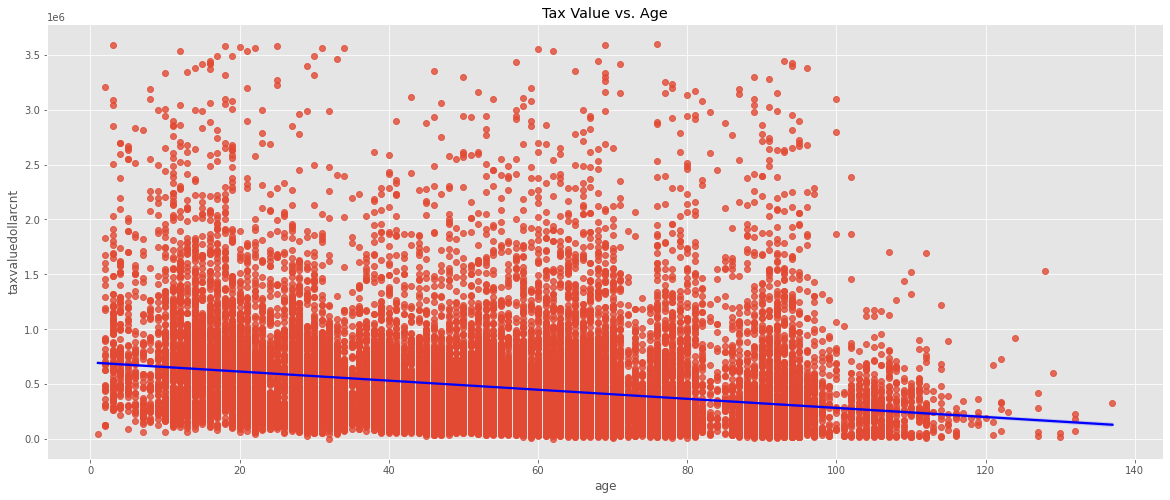

In [12]:
# lets pull a scatter plot to see
evaluate.q4_graph(train)


## Feature Engineering

Here I will create new features through scaling as see if they help the model through RFE(Recursive Feature Elimination).

In [13]:
# first we need to split the data into features and target
X_train, y_train = prepare.split_x_y(train, 'taxvaluedollarcnt')
X_validate, y_validate = prepare.split_x_y(validate, 'taxvaluedollarcnt')
X_test, y_test = prepare.split_x_y(test, 'taxvaluedollarcnt')


In [15]:
#lets let a model choose the best features
evaluate.make_rfe_ranking(X_train, y_train, n=3)

,rfe_ranking
bedroomcnt,3
bathroomcnt,2
calculatedfinishedsquarefeet,5
age,4
fips_la_county,1
fips_orange_county,1
fips_ventura_county,1


In [ ]:

#scale the data
X_train, X_validate, X_test= prepare.scale_features(X_train, X_validate, X_test)

**Summary**

1. There is a linear relationship between square feet and the value of the property.
2. There is a linear relationship between bathrooms and the value of the property.
3. There is a linear relationship between bedrooms and the value of the property.
4. There is a linear relationship between the buildings age and the value of the property.
5. Location also appears important in predicting the value of the property as seen by the RFE.
    (RFE is a feature selection algorithm)

These features will be a great starting point for building a predictive model. Our first model will take the first three features mentioned then more combinations will be attempted from the above listed. It is important to note that several other features are also available, but due to time constraints we will not explore them yet.

## Modeling
First a baseline model is created and evaulated. The two most common baseline models are mean and median. We will use the best performing model based of of RMSE. RMSE will be the metric used to evaluate the models thereafter because it is a measure of the error in units relevant to the data (ie. how far off in dollars are we on average).

In [22]:
# In the explore notebook, I found that the best baseline is based on mean
# here are the stats baseline model based on mean
# set the baseline as the RMSE using mean on validate
baseline_train = evaluate.baseline_mean_errors(y_train)['RMSE']
baseline_validate = evaluate.baseline_mean_errors(y_validate)['RMSE']
baseline_train, baseline_validate

(441735.4335987771, 443652.55233791796)

In [23]:
# build a dataframe to store rmse values
#results = pd.DataFrame(columns=['model_number','model_type','RMSE_train','RMSE_validate','baseline','better_than_baseline'])
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','RMSE_train':baseline_train,'RMSE_validate':baseline_validate,'baseline':baseline_train,'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline
0,baseline,baseline,441735.433599,443652.552338,441735.433599,False


Per project specs:

    "For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product)."

In [25]:
#choose the features per project specifications
features = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']
# make and fit the model
model1 = LinearRegression().fit(X_train[features], y_train)
# make predictions
y_train_pred = model1.predict(X_train[features])
y_validate_pred = model1.predict(X_validate[features])
# compute the RMSE
rmse_train = mean_squared_error(y_train, y_train_pred)**(1/2)
rmse_validate = mean_squared_error(y_validate, y_validate_pred)**(1/2)
# add the rmse to the results dataframe
model_results = pd.Series({'model_number':1,
    'model_type':'Linear Regression',
    'RMSE_train':rmse_train,
    'RMSE_validate':rmse_validate,
    'baseline':baseline_train,
    'better_than_baseline':rmse_train<baseline_train})
# concat the results dataframe
results = pd.concat([results, model_results],axis = 1)
# transpose it so each row is a model
results.T.reset_index(drop=True)

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline
0,baseline,baseline,441735.433599,443652.552338,441735.433599,False
1,1,Linear Regression,352412.022916,350743.374872,441735.433599,True


Below I run 2000+ models and add them to the results

In [26]:
# lets make more linear models using various combinations of features and see which one performs better
# make a list of all the features
features = X_train.columns.tolist()
# lets track top features by making an empty array and dummy score
# each model will compare to current best and set itself as best if higher
best_features =[]
best_score = baseline_validate
model_type = 'Linear Regression'
#make a model counter
model_number = 2 # starts at 2 because first model already made
#make a list of all combinations of features
combinations = []
for i in range(1, len(features)+1):
    combinations.extend(list(itertools.combinations(features,i)))
#iterate between 1 and all top features
#iterate between 1 and all top features
for combination in combinations:
    #build
    model = LinearRegression()
    #convert list to array to pass into function
    features = np.array(combination)
    #fit on the combination determined above
    model.fit(X_train[features], y_train)
    # make predictions
    y_train_pred = model.predict(X_train[features])
    y_validate_pred = model.predict(X_validate[features])
    # compute the RMSE
    rmse_train = mean_squared_error(y_train, y_train_pred)**(1/2)
    rmse_validate = mean_squared_error(y_validate, y_validate_pred)**(1/2)
    #build df
    stats = pd.Series({"model_number": model_number,
        "model_type": model_type,
        "number_of_features": len(features),
        "RMSE_train": rmse_train,
        "RMSE_validate": rmse_validate,
        "baseline": baseline_train,
        "better_than_baseline": rmse_train<baseline_train})
    # increase model counter
    model_number += 1
    results = pd.concat([results,stats],axis =1)
    # this could be done in the df but its a large output, array of up to len(best_features) strings
    # strings could be converted to index values to be more concise
    if rmse_validate < best_score:
        #reset best
        best_score = rmse_validate
        #save best features
        best_features = features

# transpose and reset the index to make it cleaner
results.T.reset_index(drop=True)

,model_number,model_type,RMSE_train,RMSE_validate,baseline,better_than_baseline,number_of_features
0,baseline,baseline,441735.433599,443652.552338,441735.433599,False,NaN
1,1,Linear Regression,352412.022916,350743.374872,441735.433599,True,NaN
2,2,Linear Regression,425721.095108,425683.870249,441735.433599,True,1
3,3,Linear Regression,380182.462078,375466.582502,441735.433599,True,1
4,4,Linear Regression,358931.94084,357040.549586,441735.433599,True,1
...,...,...,...,...,...,...,...
2044,2044,Linear Regression,349433.14854,347359.314364,441735.433599,True,10
2045,2045,Linear Regression,349433.14854,347359.314364,441735.433599,True,10
2046,2046,Linear Regression,349433.14854,347359.314364,441735.433599,True,10
2047,2047,Linear Regression,349433.14854,347359.314364,441735.433599,True,10


Sort and pick the best performing model

In [28]:
# lets get the model number from the top performer
# get the model number from the top performer
top_model_number = results.T.reset_index(drop=True).sort_values(by = ['RMSE_validate','RMSE_train'], ascending = True).iloc[0]['model_number']
top_model_number, best_features


(1972,
 array(['bathroomcnt', 'fips_la_county', 'fips_orange_county',
        'fips_ventura_county', 'scaled_bedroomcnt', 'scaled_bathroomcnt',
        'scaled_calculatedfinishedsquarefeet', 'scaled_age'], dtype='<U35'))

Here I run the Test data set on the top model

In [30]:
# rebuild the best model
model = LinearRegression()
#convert list to array to pass into function
features = best_features.tolist()
#fit on the combination determined above
model.fit(X_train[features], y_train)
# make predictions
y_train_pred = model.predict(X_train[features])
y_validate_pred = model.predict(X_validate[features])
y_test_pred = model.predict(X_test[features])
# compute the RMSE
rmse_train = mean_squared_error(y_train, y_train_pred)**(1/2)
rmse_validate = mean_squared_error(y_validate, y_validate_pred)**(1/2)
rmse_test = mean_squared_error(y_test, y_test_pred)**(1/2)
#build df
stats = pd.Series({"model_number": top_model_number,
    "model_type": model_type,
    "number_of_features": len(features),
    "RMSE_train": rmse_train,
    "RMSE_validate": rmse_validate,
    "RMSE_test": rmse_test,
    "baseline": baseline_train,
    "better_than_baseline": rmse_train<baseline_train})

#show the results of the best model
stats

model_number                         1972
model_type              Linear Regression
number_of_features                      8
RMSE_train                  349433.472518
RMSE_validate               347354.912092
RMSE_test                   345867.052513
baseline                    441735.433599
better_than_baseline                 True
dtype: object

## Modeling summary
2000+ models were run but all are linear regression. With more time I would like to try out more complex models with even more feature combinations.

However, the best model performed 100K better on the test set than the baseline model did on the train set.

## CONCLUSION
### Drivers of churn
All the features seem important in predicting the value of the property but the number of bathrooms appears the most important.
Sqft was not as important as expected and I would like to delve into that more given more time.

### Model improvement
Our models almost all perform better than the baseline model. With one having a RMSE of $100k better than the baseline. I would like to try different ways to scale the data and remove outliers.

### Recommendations
More features I would add in would be lot size, long/lat (or other available location info), and potentially pull data to determine proximity to schools, hospitals, and determine crime rate.
